In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns

# Clustering

In [341]:
#limits data to genes with median expression > 0 
fpkm = pd.read_csv('all_annotated.csv')
fpkm['Keep']=np.where(fpkm.median(axis=1,numeric_only=True)>0,True,False)
fpkm = fpkm.loc[fpkm['Keep'] == True]
fpkm=fpkm.drop(['Keep'], axis = 1)

In [342]:
#log2 transformation 
log_fpkm=fpkm.apply(lambda x:np.log2(x+0.1) if np.issubdtype(x.dtype, np.number) else x)
log_fpkm

,t_name,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
3,FBtr0302347,CR40182,4.573651,3.593093,4.383186,3.772605,4.240476,4.749679,4.518529,3.558602,4.459054,3.809626,4.051558,3.669331,4.995485,4.522507,3.851021,4.112914
8,FBtr0113885,Parp,3.472120,-3.321928,-3.321928,-3.321928,3.897757,-3.321928,4.145813,3.436875,-3.321928,-3.321928,3.905799,3.869772,4.353582,2.066050,-3.321928,4.665883
9,FBtr0301810,Alg-2,4.260622,-3.321928,3.900371,4.801878,4.484797,2.990301,3.801070,3.701063,4.222705,1.594158,4.209672,4.729653,4.784754,2.913181,2.897078,4.516802
10,FBtr0113895,Tim17b,2.681610,2.012708,2.665469,6.130167,6.072718,2.945977,6.230339,5.750615,5.486961,4.081859,5.728691,6.286330,6.338167,4.998373,5.621212,6.280001
11,FBtr0345179,Tim17b,6.899972,3.552258,6.909741,6.245611,6.188155,6.953605,6.345793,5.901059,5.602316,4.196805,5.844084,6.439396,6.453632,5.113628,5.736589,6.410012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,FBtr0100884,mt:Cyt-b,5.063561,0.209330,3.312209,8.696872,6.681296,4.675181,6.166922,6.945737,6.905339,-0.371506,5.597221,6.170259,7.891809,5.452891,6.239269,7.386673
34665,FBtr0100886,mt:ND1,4.661599,-0.437467,4.418274,9.014515,8.350559,5.778312,8.493319,7.797501,8.259794,1.172241,7.649749,8.615611,8.760742,4.441070,6.523595,9.412730
34667,FBtr0100888,mt:lrRNA,11.191931,5.095088,9.857502,12.271701,11.136488,9.213941,11.283776,10.690080,11.332554,6.260317,11.087133,11.867576,6.942632,8.818194,9.435277,12.153787
34684,FBtr0114261,CR41590,-2.534805,-3.321928,-2.348207,-2.301821,-3.321928,-3.321928,-3.321928,-2.143405,0.003268,-3.321928,-3.321928,-1.927886,-1.913863,-3.321928,-3.321928,-2.713053


subset = log_fpkm.drop(['t_name', 'gene_name'], axis=1)
cluster = subset.to_numpy()
cluster_trans=np.transpose(cluster)
z=linkage(cluster)
z_trans=linkage(cluster_trans)

In [343]:
#clustering
subset = log_fpkm.drop(['t_name', 'gene_name'], axis=1)

cluster = subset.values
cluster_trans=np.transpose(cluster)

link=linkage(cluster)
link_trans=linkage(cluster_trans)

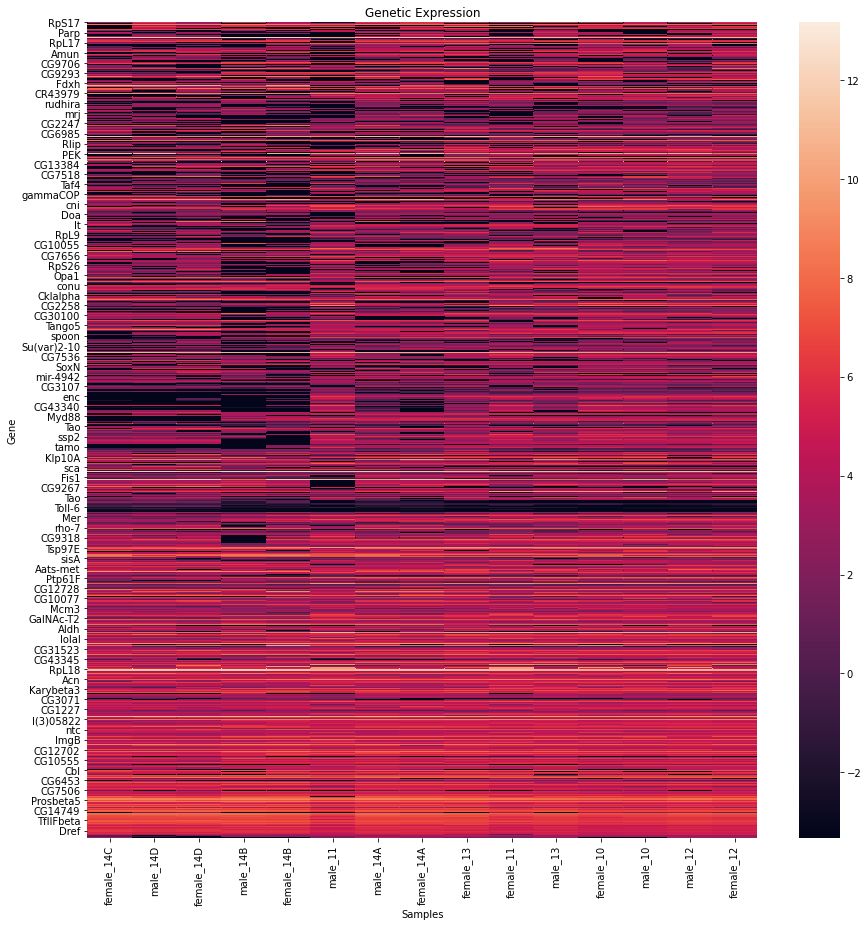

In [345]:
log_fpkm_array = log_fpkm.values

labels = leaves_list(link)
gene_names = []
sample_labels=leaves_list(link_trans)
col_names = []

#reorder and compile gene names
for x in labels:
    gene_names.append(log_fpkm_array[x][1])
    
cols=log_fpkm.columns.tolist()[2:]

#sample names
for y in sample_labels:
    col_names.append(cols[y])

#construct dataframe for heatmap
log_fpkm = log_fpkm.set_index('gene_name')
log_fpkm_gene = log_fpkm.loc[gene_names]
fig, ax= plt.subplots(figsize=(15,15))
log_fpkm_col = log_fpkm_gene[col_names]

#heatmap
ax=sns.heatmap(log_fpkm_col.iloc[:, 1:])
ax.set_title("Genetic Expression")
ax.set_xlabel("Samples")
ax.set_ylabel("Gene")
plt.show()

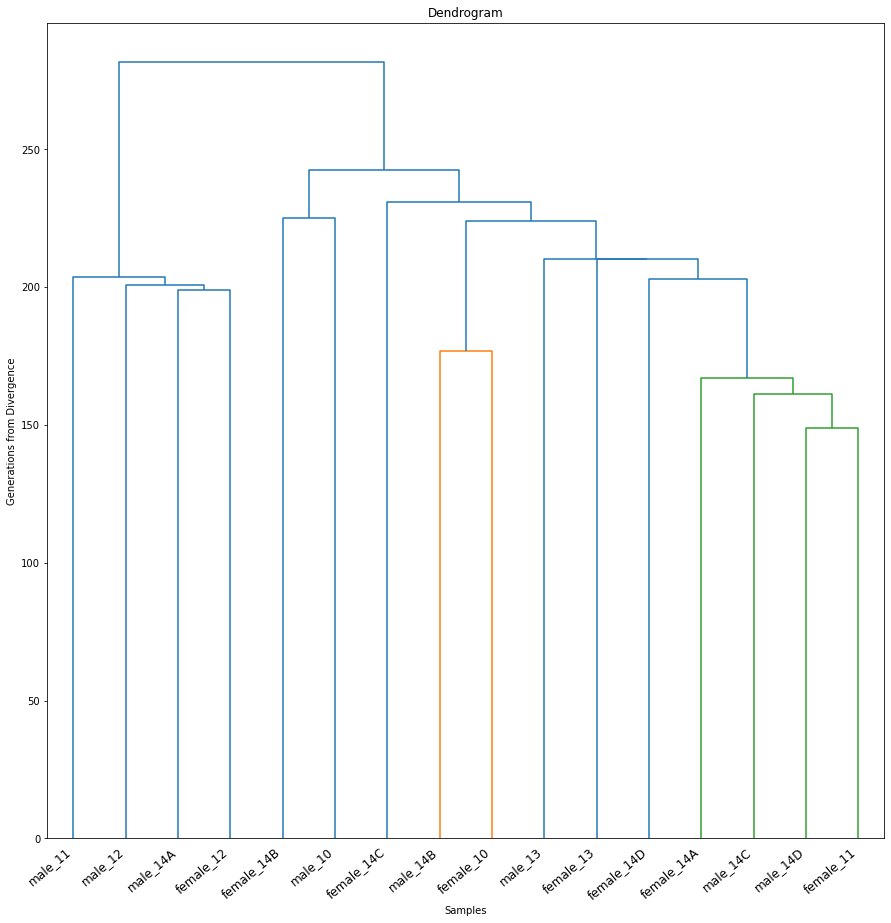

In [348]:
#dendrogram labeled with same sample list
fig,ax=plt.subplots(figsize=(15,15))
dendrogram(link_trans,p=16, truncate_mode='level',labels=col_names)
plt.xticks(rotation=40, ha='right')
ax.set_title("Dendrogram")
ax.set_xlabel("Samples")
ax.set_ylabel("Generations from Divergence")
plt.show()

# Differential Gene Expression 

In [358]:
#transpose log_fpkm dataframe and add sex and day columns for DE
log_fpkm = log_fpkm.set_index('t_name')

sex = log_fpkm.columns
sex_list = []
day = []

for n in sex:
    if 'fe' in n:
        sex_list.append('female')
        if 'A'in n or 'B' in n or 'C' in n or 'D' in n:
            day.append(int(14))
        else:
            day.append(int(n[-2:]))
    else:
        sex_list.append('male')
        if 'A'in n or 'B' in n or 'C' in n or 'D' in n:
            day.append(int(14))
        else:
            day.append(int(n[-2:]))

log_fpkm.loc['sex'] = sex_list
log_fpkm.loc['age'] = day
log_fpkm_transtest = log_fpkm.transpose()
log_fpkm_transtest
#columns labeled with t_name rather than gene because of duplicates

t_name,FBtr0302347,FBtr0113885,FBtr0301810,FBtr0113895,FBtr0345179,FBtr0301812,FBtr0113990,FBtr0113989,FBtr0078962,FBtr0078964,...,FBtr0100870,FBtr0100877,FBtr0100879,FBtr0100884,FBtr0100886,FBtr0100888,FBtr0114261,FBtr0114216,sex,age
male_10,4.57365,3.47212,4.26062,2.68161,6.89997,2.70509,4.75646,3.14647,-3.32193,3.46393,...,-3.32193,2.77647,3.49208,5.06356,4.6616,11.1919,-2.5348,1.07806,male,10
male_11,3.59309,-3.32193,-3.32193,2.01271,3.55226,-3.32193,-3.32193,-3.32193,-3.32193,4.23906,...,-3.32193,-1.47013,-1.02401,0.20933,-0.437467,5.09509,-3.32193,-3.32193,male,11
male_12,4.38319,-3.32193,3.90037,2.66547,6.90974,3.38764,-3.32193,4.65375,-3.32193,4.67025,...,-3.32193,3.67005,2.11786,3.31221,4.41827,9.8575,-2.34821,3.01688,male,12
male_13,3.77261,-3.32193,4.80188,6.13017,6.24561,4.52975,4.85263,4.09329,-3.32193,4.08372,...,-3.32193,5.76376,6.54958,8.69687,9.01452,12.2717,-2.30182,1.11383,male,13
male_14A,4.24048,3.89776,4.4848,6.07272,6.18816,4.65837,4.89247,2.50752,3.46578,4.07881,...,5.24796,5.72629,6.44864,6.6813,8.35056,11.1365,-3.32193,1.69674,male,14
male_14B,4.74968,-3.32193,2.9903,2.94598,6.95361,4.43548,-3.32193,-3.32193,4.83997,-3.32193,...,-3.32193,2.67673,4.50141,4.67518,5.77831,9.21394,-3.32193,-3.32193,male,14
male_14C,4.51853,4.14581,3.80107,6.23034,6.34579,5.11012,4.42178,-3.32193,6.83412,3.48419,...,5.11985,5.72382,6.19377,6.16692,8.49332,11.2838,-3.32193,0.695194,male,14
male_14D,3.5586,3.43687,3.70106,5.75061,5.90106,4.14388,2.42338,3.73393,7.22232,-3.32193,...,4.60372,3.96227,5.82369,6.94574,7.7975,10.6901,-2.1434,3.2158,male,14
female_10,4.45905,-3.32193,4.2227,5.48696,5.60232,3.8855,4.15723,3.63683,-3.32193,4.53384,...,2.24717,3.42726,5.37293,6.90534,8.25979,11.3326,0.00326833,3.76295,female,10
female_11,3.80963,-3.32193,1.59416,4.08186,4.1968,2.03595,-3.32193,-3.32193,-3.32193,3.09516,...,-3.32193,-0.163229,-1.37436,-0.371506,1.17224,6.26032,-3.32193,0.904145,female,11


In [364]:
#convert columns to floats
for f in log_fpkm_transtest.columns:
    if 'sex' in str(f):
        pass
    else:
        log_fpkm_transtest[f] = pd.to_numeric(log_fpkm_transtest[f], errors = 'coerce')

In [371]:
#ordinary least squares regression test looking only at age
pvalues = []
for t_name in log_fpkm_transtest.columns:
    
    if 'sex' not in t_name or 'age' in t_name:
        model = smf.ols(formula = str(t_name + '~ age'), data = log_fpkm_transtest)
        results=model.fit()
        pvalues.append([t_name, np.array(results.pvalues)[1]])

In [372]:
pvalues

[['FBtr0302347', 0.7358926183273347],
 ['FBtr0113885', 0.16237784160696606],
 ['FBtr0301810', 0.26308004504563715],
 ['FBtr0113895', 0.03152074074983892],
 ['FBtr0345179', 0.22144463001227804],
 ['FBtr0301812', 0.026844794625964837],
 ['FBtr0113990', 0.7939593130971245],
 ['FBtr0113989', 0.9449779686993145],
 ['FBtr0078962', 8.450609073393468e-05],
 ['FBtr0078964', 0.045766364985725005],
 ['FBtr0336702', 0.05989603740251784],
 ['FBtr0078966', 0.5028285248161207],
 ['FBtr0336705', 0.9795607227302616],
 ['FBtr0078985', 2.0276528119357636e-06],
 ['FBtr0078967', 1.1968695253504114e-06],
 ['FBtr0078958', 0.00037275166785971734],
 ['FBtr0336484', 0.16985732753180446],
 ['FBtr0336483', 0.5699473374035591],
 ['FBtr0078955', 0.015965380011706186],
 ['FBtr0078953', 0.10860866904290113],
 ['FBtr0344740', 0.1853707744930279],
 ['FBtr0078909', 0.19443903619081918],
 ['FBtr0111220', 0.5841333735689256],
 ['FBtr0078951', 6.308140979502167e-10],
 ['FBtr0078914', 0.01497927689587596],
 ['FBtr0078915', 

In [198]:
#create copies of sorted and unsorted pvalues for QQ and beyond
pvalues_unsorted = []
pvalues2 = []
for p in pvalues:
    pvalues_unsorted.append(p[1])
    
pvalues2 = pvalues_unsorted.copy()
    

In [201]:
#sorting and log transformation of pvalues before QQ
pvalues2.sort(reverse=False)
uniform_points=[(x+1)/len(pvalues2) for x in range(len(pvalues2))]
log_uniform_points=[-1*np.log10(x) for x in uniform_points]
log_pvalues=[-1*np.log10(x) for x in pvalues2]

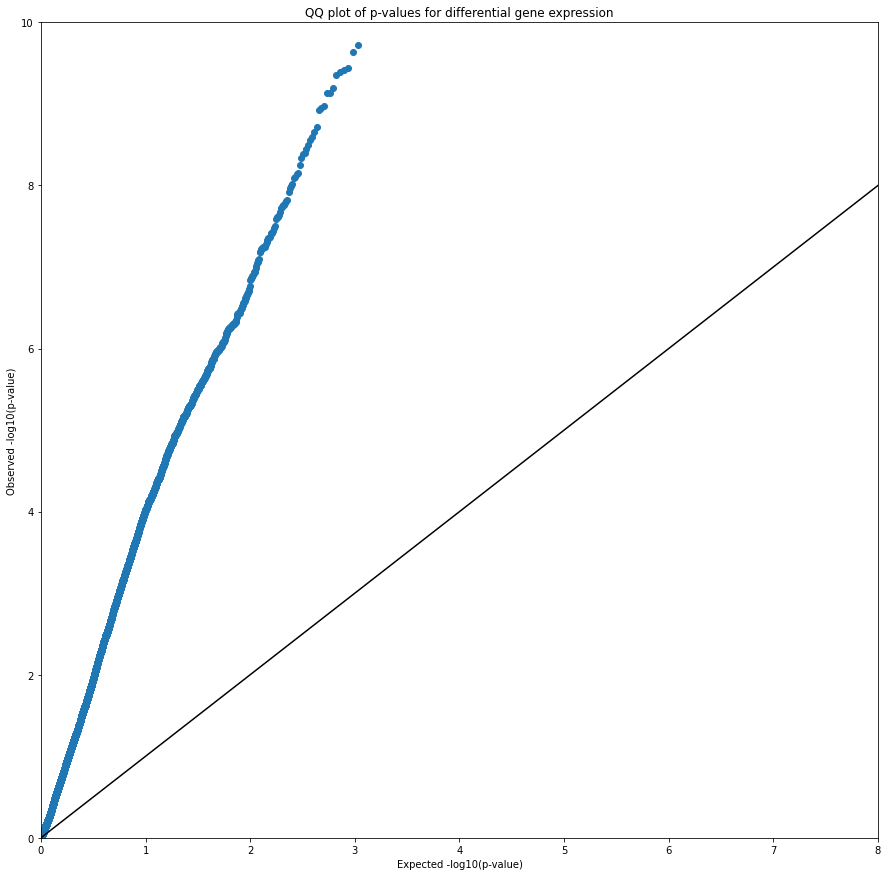

In [374]:
##QQ plot
fig, ax = plt.subplots(figsize = (15, 15))

ax.scatter(log_uniform_points, log_pvalues)
ax.plot([8,0], [8, 0], color = "black")

plt.xlim([0, 8])
plt.ylim([0, 10])
plt.xlabel("Expected -log10(p-value)")
plt.ylabel("Observed -log10(p-value)")
ax.set_title("QQ plot of p-values for differential gene expression")
plt.show()

In [380]:
# Test for false discovery rate 
corrected_fdr_values=fdrcorrection(pvalues_unsorted,alpha=0.1)
i=0

corrected_genes = []
for i in range(len(corrected_fdr_values[0])):
    if corrected_fdr_values[1][i] < 0.1:
        corrected_genes.append(pvalues[i][0])
print("Significant differential expression after fdr correction")
print(corrected_genes)

Significant differential expression after fdr correction
['FBtr0113895', 'FBtr0301812', 'FBtr0078962', 'FBtr0078985', 'FBtr0078967', 'FBtr0078958', 'FBtr0078955', 'FBtr0078951', 'FBtr0078914', 'FBtr0078915', 'FBtr0339552', 'FBtr0078950', 'FBtr0290222', 'FBtr0078921', 'FBtr0078946', 'FBtr0078944', 'FBtr0078938', 'FBtr0078935', 'FBtr0299947', 'FBtr0078928', 'FBtr0078894', 'FBtr0301297', 'FBtr0078859', 'FBtr0078892', 'FBtr0302614', 'FBtr0078868', 'FBtr0078876', 'FBtr0078837', 'FBtr0308120', 'FBtr0078822', 'FBtr0078821', 'FBtr0334276', 'FBtr0344333', 'FBtr0334275', 'FBtr0344334', 'FBtr0078806', 'FBtr0078805', 'FBtr0078787', 'FBtr0100433', 'FBtr0330026', 'FBtr0078682', 'FBtr0078767', 'FBtr0344635', 'FBtr0344273', 'FBtr0078766', 'FBtr0344274', 'FBtr0336770', 'FBtr0078761', 'FBtr0078758', 'FBtr0078688', 'FBtr0078699', 'FBtr0078751', 'FBtr0078745', 'FBtr0078704', 'FBtr0078740', 'FBtr0078705', 'FBtr0114327', 'FBtr0078706', 'FBtr0335215', 'FBtr0078737', 'FBtr0078736', 'FBtr0078712', 'FBtr0078727

In [262]:
#OLS with sex as covariate 
pvalues_sex = []
#saving beta for volcano plot
beta = []
for t_name in log_fpkm_transtest.columns:
    if 'sex' not in t_name and 'age' not in t_name:
        model = smf.ols(formula = str(t_name + '~ age + sex'), data = log_fpkm_transtest)
        results=model.fit()
        pvalues_sex.append([t_name, np.array(results.pvalues)[2]])
        beta.append(results.params[2])
results.summary()

/Users/cmdb/miniconda3/envs/cmdb/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            FBtr0114216   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.7096
Date:                Thu, 05 Nov 2020   Prob (F-statistic):              0.510
Time:                        21:54:57   Log-Likelihood:                -32.984
No. Observations:                  16   AIC:                             71.97
Df Residuals:                      13   BIC:                             74.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.2112      4.607      0.697      0.498      -6.741      13.163
sex[T.male]    -1.2085      1.055     -1.146      0.273      -3.487       1.070
age            -0.1162      0.357     -0.326      0.750      -0.886       0.654
==============================================================================
Omnibus:                        2.132   Durbin-Watson:                   2.281
Prob(Omnibus):                  0.344   Jarque-Bera (JB):                1.340
Skew:                          -0.700   Prob(JB):                        0.512
Kurtosis:                       2.780   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [263]:
#filtering out t_names for now
pvalues_unsorted_sex = []
for p in pvalues_sex:
    pvalues_unsorted_sex.append(p[1])  

In [379]:
# Fdr correction after factoring in sex 

significant= []
corrected_fdr_values_sex=fdrcorrection(pvalues_unsorted_sex,alpha=0.1)
i=0

corrected_genes_sex = []
for i in range(len(corrected_fdr_values_sex[0])):
    if corrected_fdr_values_sex[1][i] < 0.1:
        corrected_genes_sex.append(pvalues_sex[i][0])
        significant.append("Yes")
    else:
        significant.append("No")
        
print("Significant differential expression controlling for sex after correction")
corrected_genes_sex

Significant differential expression controlling for sex after correction


['FBtr0113895',
 'FBtr0301812',
 'FBtr0078962',
 'FBtr0078985',
 'FBtr0078967',
 'FBtr0078958',
 'FBtr0078955',
 'FBtr0078951',
 'FBtr0078914',
 'FBtr0078915',
 'FBtr0339552',
 'FBtr0078950',
 'FBtr0290222',
 'FBtr0078921',
 'FBtr0078946',
 'FBtr0078944',
 'FBtr0078938',
 'FBtr0078935',
 'FBtr0299947',
 'FBtr0078928',
 'FBtr0078894',
 'FBtr0301297',
 'FBtr0078859',
 'FBtr0078892',
 'FBtr0302614',
 'FBtr0078868',
 'FBtr0078876',
 'FBtr0078837',
 'FBtr0308120',
 'FBtr0078822',
 'FBtr0078821',
 'FBtr0334276',
 'FBtr0344333',
 'FBtr0334275',
 'FBtr0344334',
 'FBtr0078806',
 'FBtr0078805',
 'FBtr0078787',
 'FBtr0100433',
 'FBtr0330026',
 'FBtr0078682',
 'FBtr0078767',
 'FBtr0344635',
 'FBtr0344273',
 'FBtr0078766',
 'FBtr0344274',
 'FBtr0336770',
 'FBtr0078758',
 'FBtr0078688',
 'FBtr0078699',
 'FBtr0078751',
 'FBtr0078745',
 'FBtr0078704',
 'FBtr0078740',
 'FBtr0078705',
 'FBtr0114327',
 'FBtr0078706',
 'FBtr0335215',
 'FBtr0078737',
 'FBtr0078736',
 'FBtr0078712',
 'FBtr0078727',
 'FBtr03

In [267]:
#Calculating percentage overlap between differentially expressed genes with or without factoring in sex
i=0
for gene in corrected_genes_sex:
    if gene in corrected_genes:
        i+=1
percentage_overlap = ((i/(len(corrected_genes)))*100)
print(i)
print('Percentage overlap: ' + str(percentage_overlap) + '%')

3648
Percentage overlap: 96.20253164556962%


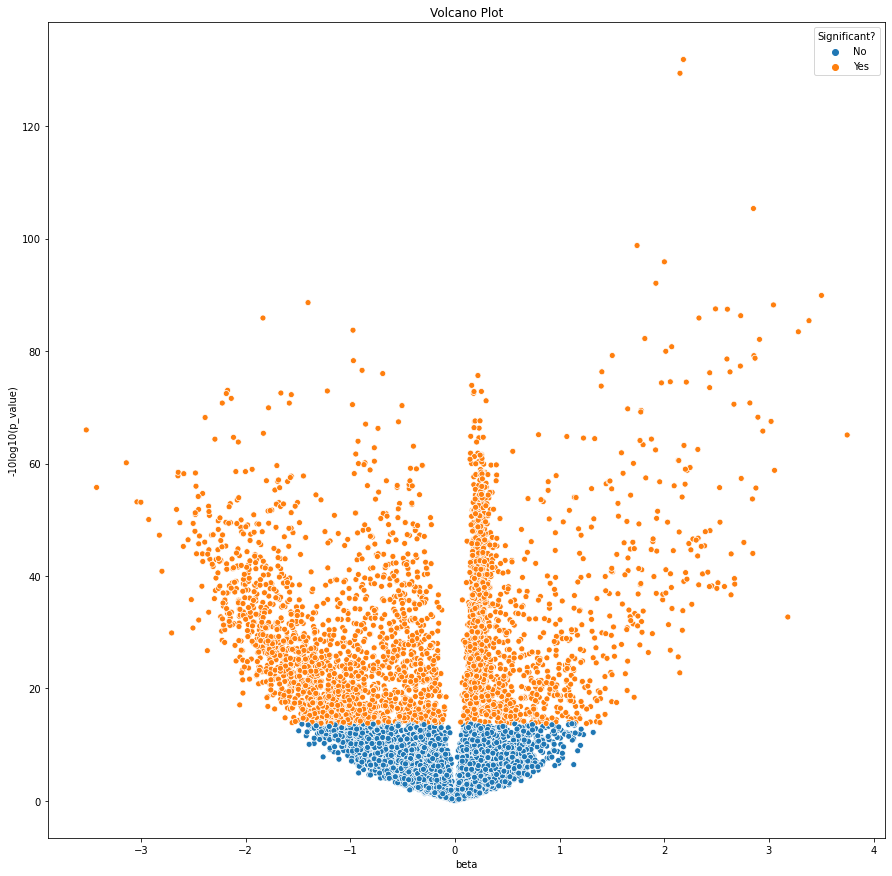

In [383]:
#Volcano plot

#create new data frame with three columns: y, x, and significance
volcano_data=pd.DataFrame({'-10log10(p_value)':-10*np.log10(pvalues_unsorted_sex),'beta': beta,'significant':significant})
fig,ax=plt.subplots(figsize=(15,15))
ax.set_title("Volcano Plot")
sns.scatterplot(data=volcano_data, x="beta",y="-10log10(p_value)",hue=volcano_data.significant.to_list())
plt.legend(title="Significant?")
plt.show()